In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2_limited",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 718.3608, train_label_loss: 2.7778, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 10414.5449, train_label_loss: 2.7384, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 10714.3609, train_label_loss: 2.6705, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 10703.0904, train_label_loss: 2.6365, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 10701.4141, train_label_loss: 2.5804, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 10737.1375, train_label_loss: 2.5542, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 10663.0042, train_label_loss: 2.6227, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 10656.2299, train_label_loss: 2.6511, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 10624.7218, train_label_loss: 2.5138, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 10538.0223, train_label_loss: 2.5084, 


epoch: 1, source_val_acc_label: 0.1957, source_val_label_loss: 2.4470, target_val_acc_label: 0.1957, target_val_label_loss: 2.4470, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 49.3976, train_label_loss: 2.3700, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 10632.8446, train_label_loss: 2.3764, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 10679.1285, train_label_loss: 2.3556, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 10675.8385, train_label_loss: 2.3159, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 10687.9210, train_label_loss: 2.2654, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 10686.9241, train_label_loss: 2.2033, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 10667.9410, train_label_loss: 2.2852, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 10663.0329, train_label_loss: 2.1754, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 10657.3677, train_label_loss: 2.0708, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 10658.5042, train_label_loss: 2.1952, 


epoch: 2, source_val_acc_label: 0.3189, source_val_label_loss: 2.0318, target_val_acc_label: 0.3189, target_val_label_loss: 2.0318, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 61.9515, train_label_loss: 2.0500, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11635.0897, train_label_loss: 1.9189, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11692.0563, train_label_loss: 2.0897, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11697.9703, train_label_loss: 1.8088, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11698.4820, train_label_loss: 1.7586, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11634.0332, train_label_loss: 1.8309, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11720.7434, train_label_loss: 1.8073, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11645.7267, train_label_loss: 1.7717, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11664.0703, train_label_loss: 1.6839, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11617.3279, train_label_loss: 1.4951, 


epoch: 3, source_val_acc_label: 0.4486, source_val_label_loss: 1.6389, target_val_acc_label: 0.4486, target_val_label_loss: 1.6389, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 63.2433, train_label_loss: 1.4483, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11656.8611, train_label_loss: 1.5334, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11652.8874, train_label_loss: 1.5287, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 11681.2499, train_label_loss: 1.4915, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 11604.5106, train_label_loss: 1.3714, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11732.0808, train_label_loss: 1.6389, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11585.1875, train_label_loss: 1.4591, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11656.6844, train_label_loss: 1.2836, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11650.4706, train_label_loss: 1.5415, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11716.8279, train_label_loss: 1.5190, 


epoch: 4, source_val_acc_label: 0.4741, source_val_label_loss: 1.5135, target_val_acc_label: 0.4741, target_val_label_loss: 1.5135, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 63.9561, train_label_loss: 1.2880, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11729.4956, train_label_loss: 1.2690, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11762.3343, train_label_loss: 1.2600, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 12047.3875, train_label_loss: 1.1703, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11845.2840, train_label_loss: 1.0167, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11799.7979, train_label_loss: 1.3162, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11780.4546, train_label_loss: 1.0270, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11763.0651, train_label_loss: 1.0531, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11727.1513, train_label_loss: 1.2243, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11728.7964, train_label_loss: 1.0572, 


epoch: 5, source_val_acc_label: 0.4835, source_val_label_loss: 1.4685, target_val_acc_label: 0.4835, target_val_label_loss: 1.4685, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 64.2415, train_label_loss: 0.9024, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11672.1455, train_label_loss: 0.9568, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11714.6109, train_label_loss: 0.9524, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11835.5343, train_label_loss: 1.0103, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11764.4478, train_label_loss: 0.9063, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11745.4496, train_label_loss: 0.9948, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11815.1656, train_label_loss: 0.8873, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11842.1150, train_label_loss: 0.7614, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11800.5778, train_label_loss: 1.1689, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 12088.0429, train_label_loss: 0.7928, 


epoch: 6, source_val_acc_label: 0.5087, source_val_label_loss: 1.4055, target_val_acc_label: 0.5087, target_val_label_loss: 1.4055, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 65.0292, train_label_loss: 0.6068, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11790.2633, train_label_loss: 0.7764, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11744.0824, train_label_loss: 0.7028, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11796.2218, train_label_loss: 0.7376, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11761.3109, train_label_loss: 0.6498, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11764.3834, train_label_loss: 0.7712, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11758.0249, train_label_loss: 0.6273, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 11768.6735, train_label_loss: 0.8724, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11790.9793, train_label_loss: 0.8246, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11773.7947, train_label_loss: 0.7419, 


epoch: 7, source_val_acc_label: 0.4800, source_val_label_loss: 1.4895, target_val_acc_label: 0.4800, target_val_label_loss: 1.4895, 


epoch: 8, [batch: 1 / 1400], examples_per_second: 65.0006, train_label_loss: 0.5232, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 11682.7896, train_label_loss: 0.5347, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11772.1886, train_label_loss: 0.4365, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11772.3748, train_label_loss: 0.4942, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11744.9321, train_label_loss: 0.5607, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11797.9272, train_label_loss: 0.7725, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11732.4727, train_label_loss: 0.6824, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11653.6498, train_label_loss: 0.4885, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11770.1792, train_label_loss: 0.6878, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11720.6630, train_label_loss: 0.5663, 


epoch: 8, source_val_acc_label: 0.4899, source_val_label_loss: 1.5561, target_val_acc_label: 0.4899, target_val_label_loss: 1.5561, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 65.4724, train_label_loss: 0.4580, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11710.7519, train_label_loss: 0.5500, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11739.2895, train_label_loss: 0.4082, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11722.6829, train_label_loss: 0.3655, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11824.7403, train_label_loss: 0.3726, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11742.7173, train_label_loss: 0.4584, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11728.1229, train_label_loss: 0.4423, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11693.9026, train_label_loss: 0.4049, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11797.3698, train_label_loss: 0.4471, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11719.2467, train_label_loss: 0.5305, 


epoch: 9, source_val_acc_label: 0.4763, source_val_label_loss: 1.7463, target_val_acc_label: 0.4763, target_val_label_loss: 1.7463, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 65.6614, train_label_loss: 0.3273, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11763.7838, train_label_loss: 0.2715, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11768.1281, train_label_loss: 0.3097, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11691.5761, train_label_loss: 0.2945, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11716.6416, train_label_loss: 0.3269, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11757.4216, train_label_loss: 0.2636, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11790.3578, train_label_loss: 0.5527, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11765.6209, train_label_loss: 0.3681, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11737.6249, train_label_loss: 0.3477, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11775.2501, train_label_loss: 0.3795, 


epoch: 10, source_val_acc_label: 0.4685, source_val_label_loss: 1.7964, target_val_acc_label: 0.4685, target_val_label_loss: 1.7964, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

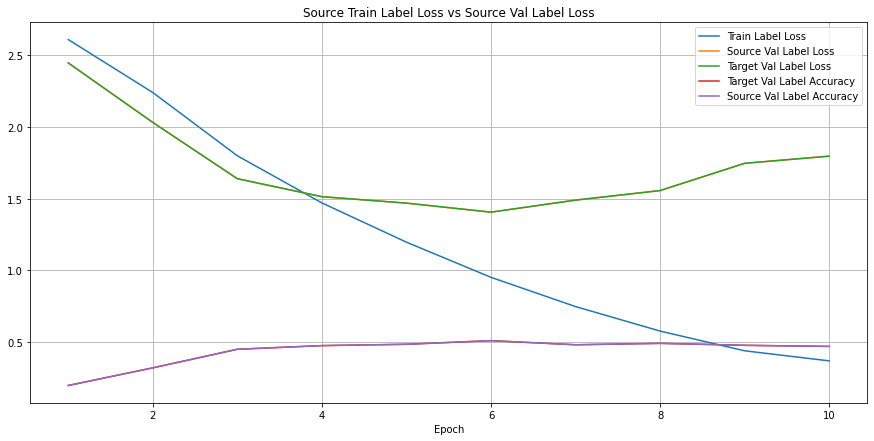

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

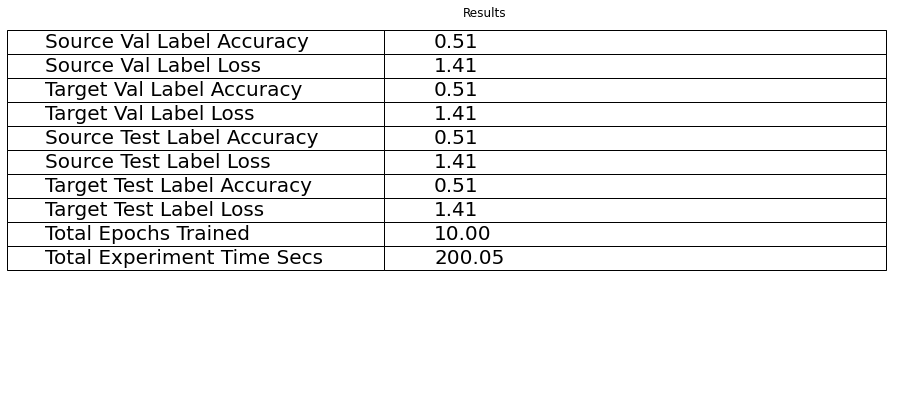

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

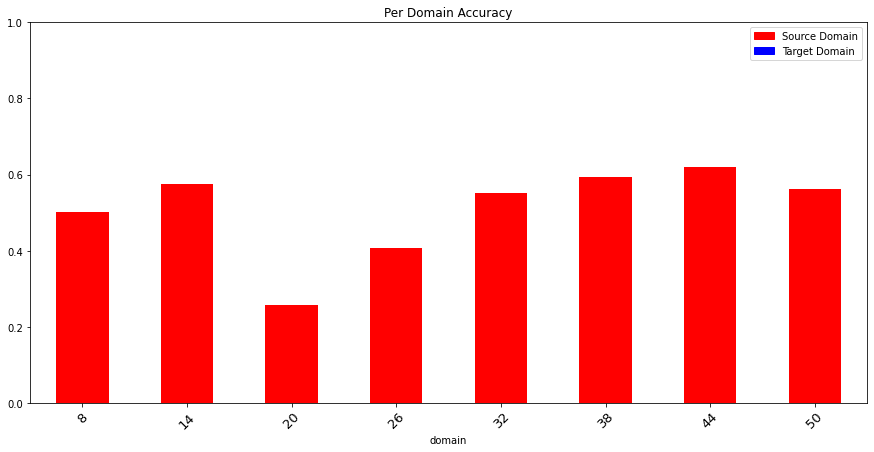

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.510859375 Target Test Label Accuracy: 0.510859375
Source Val Label Accuracy: 0.5087239583333333 Target Val Label Accuracy: 0.5087239583333333


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2_limited", "parameters": {"experiment_name": "cnn_2:oracle.run2_limited", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 2